Dans la cellule de code suivante, nous avons lancé plusieurs simulation de notre file pour observer l'évaluation du temps de réponse moyen pour chaque valeur de C {1; 2; 3; 6} en fonction de λ.

In [11]:
import routeur

LAMBDA_REQUETE = 2.3

C = 1

T_MAX = 1000

routeur.simul_fifo(LAMBDA_REQUETE, C, T_MAX)

{'temp_moyen_attente_client': 21.75162589738966, 'taux_rejet': 0.0}

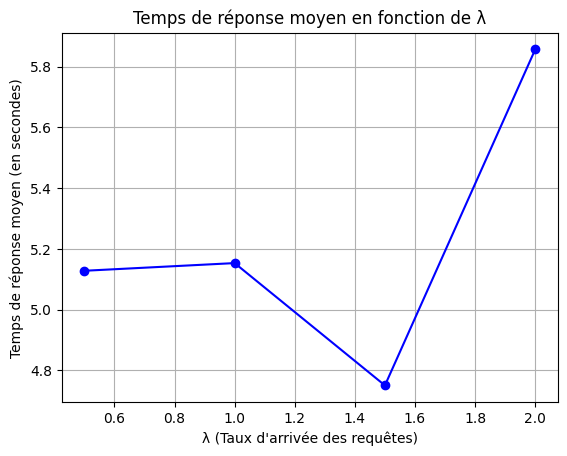

In [ ]:
import routeur
import matplotlib.pyplot as plt

# Paramètres de la simulation
C = 1
T_MAX = 1000  # Temps maximal de simulation

# Liste pour stocker les résultats
lambdas = []
temps_reponse_moyen = []

# Initialisation de lambda_requete
lambda_requete = 0.5

# Effectuer la simulation pour chaque valeur de lambda_requete
while True:
    # Simulation
    resultats = routeur.simul_fifo(lambda_requete, C, T_MAX)
    
    # Vérification du taux de rejet
    if resultats["taux_rejet"] > 0.05:
        break
    
    lambdas.append(lambda_requete)
    temps_reponse_moyen.append(resultats["temp_moyen_attente_client"])
    
    # pas de lambda_requete
    lambda_requete += 0.5

# affichage
plt.plot(lambdas, temps_reponse_moyen, marker='o', linestyle='-', color='b')
plt.title("Temps de réponse moyen en fonction de λ")
plt.xlabel("λ (Taux d'arrivée des requêtes)")
plt.ylabel("Temps de réponse moyen (en secondes)")
plt.grid(True)
plt.show()
